# Predicting medical expenses

## Dataset with USA patients demographic information

Nuno António - Rev. 1.01 - 2020-2021

### Dataset description
Simulated dataset containing medical expenses for patients in the United States. These data were created for the book "Machine Learning with R" (Lantz, B., 2013) using demographic statistics from the U.S. Census Bureau.<br>
The variables included in this dataset are:<br>
- **age**: integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).
- **sex**: policy holder's gender, either male or female.
- **bmi**: body mass index (BMI), which provides a sense of how over or under-weight a person is relative to their height. BMI is equal to weight (in kilograms) divided by height (in meters) squared. An ideal BMI is within the range of 18.5 to 24.9.
- **children**: integer indicating the number of children / dependents covered by the insurance plan.
- **smoker**: yes or no depending on whether the insured regularly smokes tobacco.
- **region**: beneficiary's place of residence in the U.S., divided into four geographic regions: northeast, southeast, southwest, or northwest.
- **charges**: the total medical expenses charged to the plan for the calendar year.

### Initial setup and modules/packages loading

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn import tree

### Data understanding

In [2]:
# Load data 
ds = pd.read_csv('medical_expenses.csv', sep=',')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
# Display top 15 rows
ds.head(15)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
# Summary statistics for all variables
summary=ds.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338,NaN,NaN,NaN,39.207,14.05,18,27,39,51,64
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338,NaN,NaN,NaN,30.6634,6.09819,15.96,26.2963,30.4,34.6938,53.13
children,1338,NaN,NaN,NaN,1.09492,1.20549,0,0,1,2,5
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338,NaN,NaN,NaN,13270.4,12110,1121.87,4740.29,9382.03,16639.9,63770.4


In [5]:
# Confirm that there are not any missing values
print(ds.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [6]:
# Transform a list of columns to categorical
cols = ['sex', 'smoker', 'region']
ds[cols] = ds[cols].apply(lambda x:x.astype('category'))

In [7]:
# Ckeck the top counts of all categorical variables
categorical=ds.select_dtypes(exclude=["number","bool_","object_"]).columns.tolist()
categorical
for var in ds[categorical]:
    print(var,":\n",ds[var].value_counts(), sep="")

sex:
male      676
female    662
Name: sex, dtype: int64
smoker:
no     1064
yes     274
Name: smoker, dtype: int64
region:
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


In [8]:
# Exploration of categorical variables: cross table of region and smoker
tb1 = pd.crosstab(index=ds['region'], columns=ds['smoker'])
tb1

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


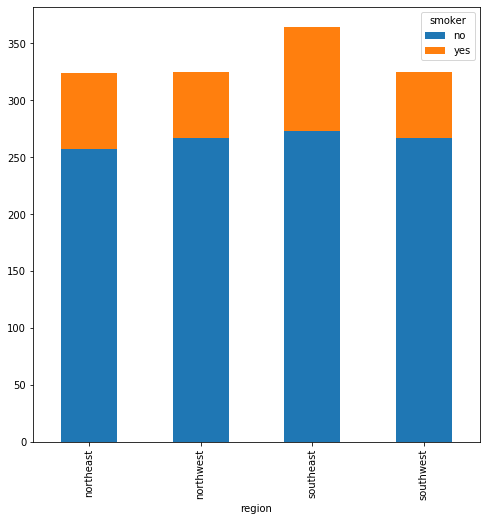

In [9]:
# Visual exploration of the cross table
tb1.plot(kind="bar", figsize=(8,8), stacked=True)

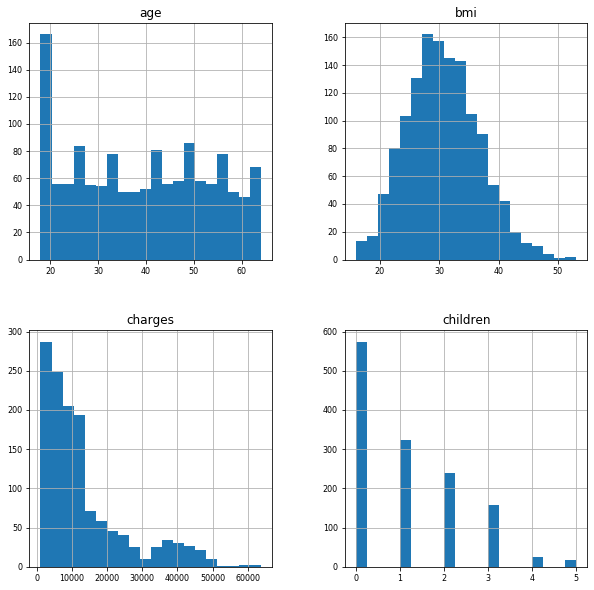

In [10]:
# Do histograms on all numeric variables
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()
ds[numerical].hist(bins=20, figsize=(10, 10), layout=(2, 2), xlabelsize=8, ylabelsize=8);

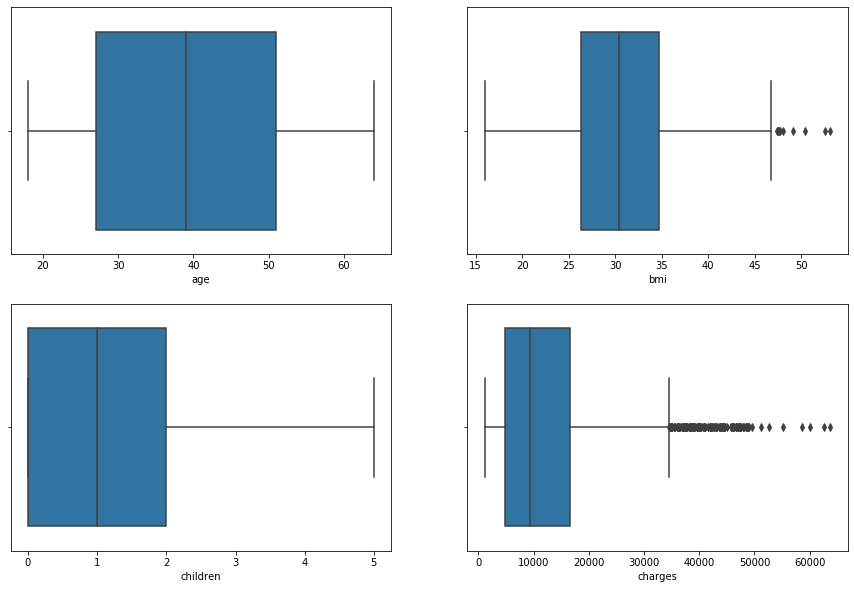

In [11]:
# Do boxplots on all numeric variables
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for var, subplot in zip(ds[numerical], ax.flatten()):
    sns.boxplot(ds[var], ax=subplot)
    

(4.0, 0.0)

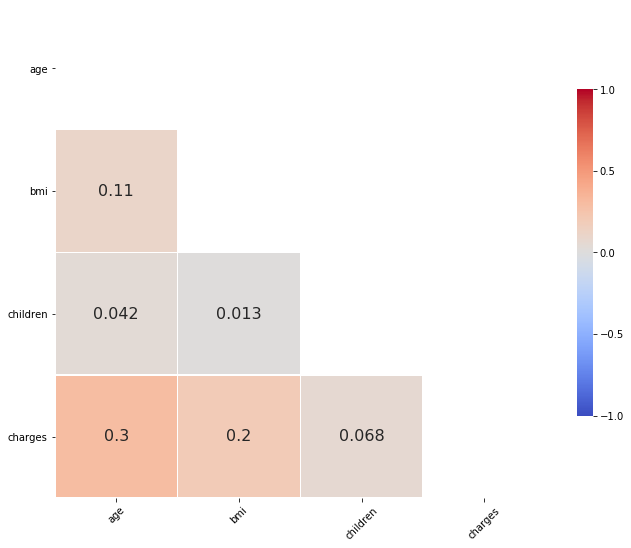

In [12]:
corr = ds[numerical].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 16})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#correct first and last line plot
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

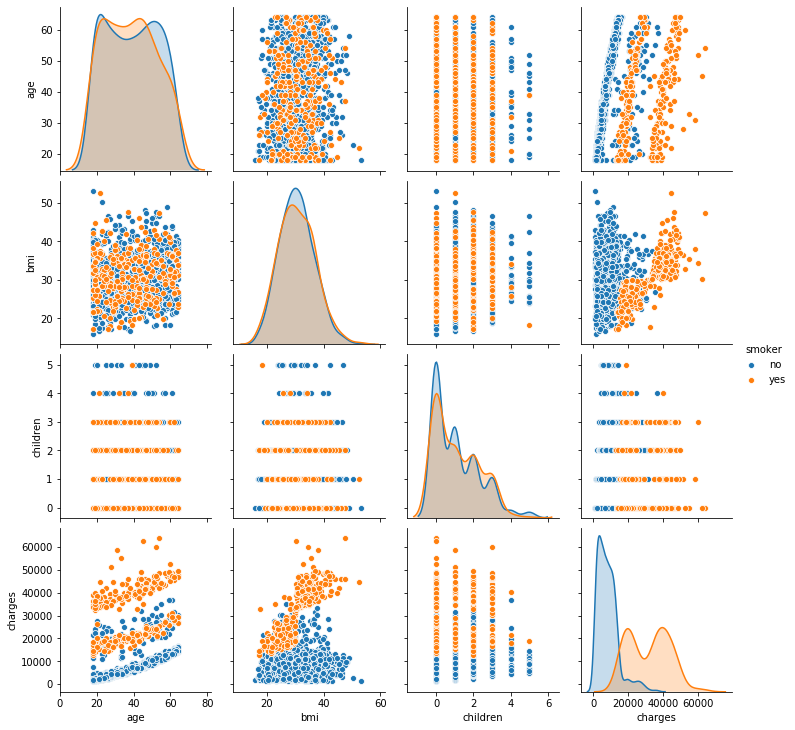

In [13]:
# Pair plot some of the numerical variables with Smoker
cols=['age','bmi','children','charges','smoker']
g = sns.pairplot(ds[cols], hue="smoker")

### Data preparation

In [14]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [15]:
# For demo purposes, let's assume high bmi and charges values are outliers
# so let's removed them
X.drop(X[X.bmi > 50].index, inplace=True)
X.drop(X[X.charges > 60000].index, inplace=True)

In [16]:
# Bin the children for children >= 3
binsInterval = [-1, 0, 1, 2, 999]
intervalLabels = ['0', '1',  '2', '3+']
X['children_binned'] = pd.cut(X['children'], bins = binsInterval, labels=intervalLabels)
# X['children'].value_counts()
# X['children_binned'].value_counts()

In [17]:
# Bin the age
binsInterval = [0, 26, 38, 50, 99] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0, 26]', '(27, 38]',  '(39, 50]', '(51, 99]']
X['age_binned'] = pd.cut(X['age'], bins = binsInterval, labels=intervalLabels)

In [18]:
# Feature engineering
# Create a feature with the ratio of the BMI by the BMI mean of people from the same age group
bmiAgeMean = X.groupby('age_binned')['bmi'].agg(meanBMI='mean') # calculate mean by age group
X['BMIByMeanBMIRatio'] = X['bmi'].divide(bmiAgeMean.meanBMI.loc[X.age_binned].values,0) # divide ADR by mean ADR of the day

In [19]:
# Encode categorical values into dummy variables
cols = cols = ['sex', 'smoker', 'region', 'age_binned', 'children_binned']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [20]:
# Find and remove outliers

# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

# Find and remove outliers
cols = ['charges', 'bmi']
X = removeOutliers(X, colList=cols , lowPercentile=0.01, highPercentile=0.99, verbose=True)

           charges       bmi
0.01   1254.668530  17.88945
0.99  47918.346019  45.50590


In [21]:
# Create the target
y = X['charges']

In [22]:
# Drop not used columns
cols = ['age', 'children', 'charges']
X = X.drop(columns=cols)

In [23]:
### NOT NEEDED FOR DECISION TREE ###

## Normalize all columns
#cols = list(X.columns) # save the name of the columns
#X_array = X.values # returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#X_scaled = min_max_scaler.fit_transform(X_array)
#X = pd.DataFrame(X_scaled, columns=cols)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1276 entries, 0 to 1337
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex_female           1276 non-null   int64  
 1   sex_male             1276 non-null   int64  
 2   bmi                  1276 non-null   float64
 3   smoker_yes           1276 non-null   int64  
 4   smoker_no            1276 non-null   int64  
 5   region_southwest     1276 non-null   int64  
 6   region_southeast     1276 non-null   int64  
 7   region_northwest     1276 non-null   int64  
 8   region_northeast     1276 non-null   int64  
 9   children_binned_0    1276 non-null   int64  
 10  children_binned_1    1276 non-null   int64  
 11  children_binned_2    1276 non-null   int64  
 12  children_binned_3+   1276 non-null   int64  
 13  age_binned_(0, 26]   1276 non-null   int64  
 14  age_binned_(27, 38]  1276 non-null   int64  
 15  age_binned_(39, 50]  1276 non-null   i

### Modeling

In [25]:
# Split the dataset intro train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 123)

In [26]:
# Function to plot the learning curve
# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

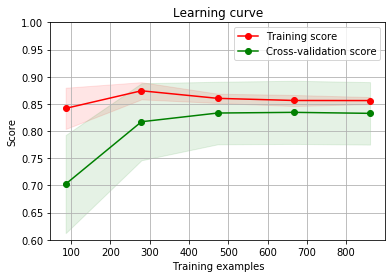

In [27]:
# Plot the learning curve
cv = 10
estimator = tree.DecisionTreeRegressor(random_state=123, max_depth=4, min_samples_leaf=5)
plot_learning_curve(estimator, "Learning curve", X_train, y_train, ylim=(0.6, 1), cv=cv, n_jobs=4,
                  train_sizes=np.linspace(0.1, 1.0, 5))

In [28]:
# Create and train the model
dt_regr = tree.DecisionTreeRegressor(random_state=123, max_depth=4, min_samples_leaf=5)
dt_regr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

In [29]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in dt_regr.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in dt_regr.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
4,smoker_no,0.709317,0.709317
2,bmi,0.158685,0.158685
16,"age_binned_(51, 99]",0.090804,0.090804
15,"age_binned_(39, 50]",0.034010,0.034010
9,children_binned_0,0.005578,0.005578
17,BMIByMeanBMIRatio,0.000911,0.000911
6,region_southeast,0.000695,0.000695
7,region_northwest,0.000000,0.000000
8,region_northeast,0.000000,0.000000
1,sex_male,0.000000,0.000000


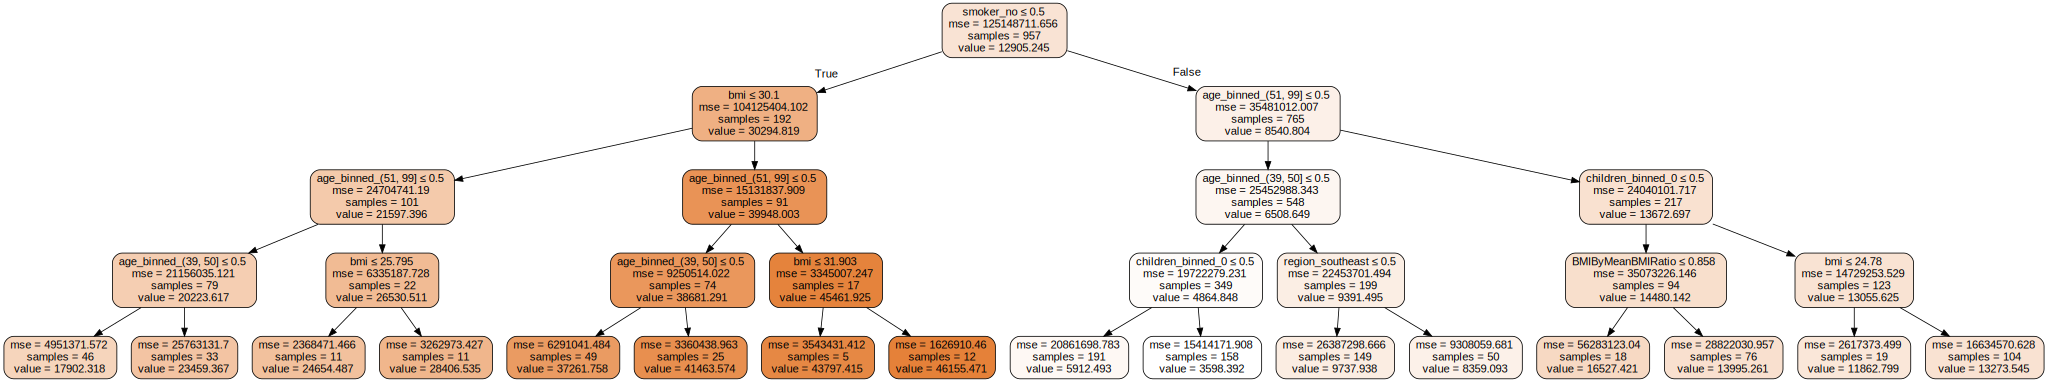

In [30]:
# Plot the tree
# Install Graphviz using "pip install graphviz" or "conda install python-graphviz"
import graphviz
dot_data = tree.export_graphviz(dt_regr, out_file=None, 
                      feature_names=list(X_train.columns),  
                      class_names='Returns',  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

<font color='blue'>C1: Explore the tree to understand the model. Remember that "values" is the average of the observations/instances in the node.</font>

### Evaluation

In [31]:
# predict y for X_train and X_test
y_pred_train = dt_regr.predict(X_train) 
y_pred_test = dt_regr.predict(X_test) 

In [32]:
# Function to calculate MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [34]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,2497.186459,2903.595119
1,RMSE,4260.316576,5113.624162
2,R^2,0.854970,0.799143
3,MAPE (%),32.291974,30.177296
4,MAX Error,22915.347471,22585.021601


<font color='blue'>C2: Change the algortihm parameters and re-run it to see what happens to results.</font>